In [523]:
import numpy as np
import pylab 
import scipy.stats as stats
import time

## Random Integers
We will generate each pseudorandom integer $n_i$ via the recursive relationship
$$
n_{i} \equiv a n_{i - 1}\pmod{m},
$$
where
$$
a = 7^5\quad\text{and}\quad m = 2^{31} - 1.
$$
This will give us random integers in the interval $[1, m)$. The integer $n_0$ is the ranom seed. We add 1 to the user specified value of the seed because a random seed of 0 is popular, though it would result in all 0's for this algorithm. When no seed is specified, we will use the time as the seed.

In [524]:
def gen_int(size = 1, seed = None):
    
    if seed is None:        
        n = int(time.time())
    else:        
        n = seed + 1
        
    a = 7**5
    
    global m    
    m = 2**31 - 1
    
    result = np.zeros(shape = size)
    
    for i in range(size):       
        n = (a * n) % m      
        result[i] = n
    
    return result
   

## Testing our distributions
We will be testing all further distributions. A qqplot will be used to test the valididity of the continuous distributions and we will check the mean, standard deviation, and skew for discrete distributions. In all cases, we will do this by generating size = 100000 random variables.

In [525]:
size = 100000

## Uniform distribution
This is a simple extension of the random integer construction. We can generate a pseudorandom uniform random variable $U_i\sim{\mathcal{U}[0, 1]}$ via
$$
U_i = \frac{n_i - 0.5}{m}.
$$
The 0.5 in the expression removes bias; if it were not there $U_i$ would tend to be slightly too large. 

It is not difficult to sample from $\mathcal{U}[a, b]$ once we are able to sample from $\mathcal{U}[0, 1]$. Simply generate $U$ from $\mathcal{U}[0, 1]$. To obtain an element of $\mathcal{U}[a, b]$, just find $(b - a) U + a$.

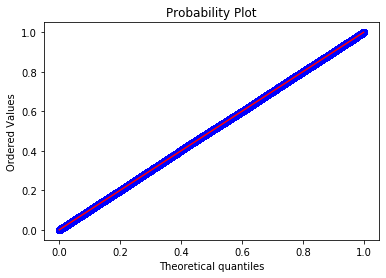

In [526]:
def gen_uni(loc = 0, scale = 1, size = 1, seed = None):
        
    result = scale * (gen_int(size = size, seed = seed) + 0.5)/m + loc
    
    return result

test_set = gen_uni(loc = 0, scale = 1, size = size, seed = 0)

stats.probplot(test_set, dist = "uniform", plot = pylab)

pylab.show()

## Bernoulli distribution
Using uniform random variables, simulating values from a Bernoulli distribution isn't too difficult. A Bernoulli random variable $X$ can either be 0 or 1. Specify the parameter $p$ of the Bernoulli distribution, which is the probability that $X = 1$. Generate a random uniform number $U$. If $U < p$, then $X = 1$, otherwise $X = 0$.

The theoretical mean, standard deviation, and skew are 
$$
p,\quad \sqrt{p(1-p)},\quad\text{and}\quad \frac{1 - 2p}{\sqrt{p(1-p)}},
$$ 
respectively. We will generate Bernoulli random variables for $p = 1/3$. As a result, the theoretical mean, standard deviation, and skew should be
$$
\frac{1}{3}\approx 0.333,\quad \frac{\sqrt{2}}{3} \approx 0.471\quad\text{and}\quad \frac{\sqrt{2}}{2}\approx 0.707
$$
respectively.


In [527]:
def gen_bern(p, size = 1, seed = None):
    
    result = (gen_uni(size = size, seed = seed) < p).astype('int')
    
    return result

p = 1/3

test_set = gen_bern(p = p, size = size, seed = 0)

results = [np.mean(test_set), np.std(test_set), stats.skew(test_set)]
results

[0.33214, 0.470980912989051, 0.7128102025820409]

## Binomial distribution 
A binomial random variable defined by the parameters $p$ and $n$ is, by definition, the sum of $n$ Bernoulli random variables each defined by parameter $p$. Hence, we only need to generate Bernoullis and sum them to obtain Binomials.

The theoretical mean, standard deviation, and skew are 
$$
np,\quad \sqrt{np(1-p)},\quad\text{and}\quad \frac{1 - 2p}{\sqrt{n p(1-p)}},
$$ 
respectively. We will generate Binomial random variables for $p = 1/3$ and $n = 16$. As a result, the theoretical mean, standard deviation, and skew should be
$$
\frac{16}{3}\approx 5.333,\quad \frac{4\sqrt{2}}{3} \approx 1.886\quad\text{and}\quad \frac{\sqrt{2}}{8}\approx 0.177
$$
respectively.

In [528]:
def gen_binom(p, n, size = 1, seed = None):
    
    result = np.reshape(gen_bern(p = p, size = n * size, seed = seed), newshape = (n, size)).sum(axis = 0)
    
    return result

p = 1/3
n = 16

test_set = gen_binom(p = p, n = n, size = size, seed = 0)

results = [np.mean(test_set), np.std(test_set), stats.skew(test_set)]
results

[5.32718, 1.8903844179425517, 0.16120921064555882]

## Poisson distribution 
This algorithm is more complicated. Fundamentally, the idea is that the expected time between Poisson events in a Poisson process follows and an exponential distribution. We will not elaborate further, but instead direct the reader to the Wikipedia article https://en.wikipedia.org/wiki/Poisson_distribution, which has a detailed explanation, including an explanation of the Knuth algorithm which we are using.

In our construction, the parameter is $\beta$. The theoretical mean, standard deviation, and skew are 
$$
\frac{1}{\beta},\quad \frac{1}{\sqrt{\beta}},\quad\text{and}\quad \sqrt{\beta},
$$
respectively. We will consider $\beta = 1/4$ in which case our respective theoretical mean, standard deviation, and skew for the distribution are
$$
4,\quad 2,\quad\text{and}\quad \frac{1}{2}.
$$

In [529]:
# Knuth algorithm
def gen_pois(beta, size = 1, seed = None):
    
    def gen_a_pois(seed):

        L = np.exp(-1/beta)
        k = 0
        p = 1
    
        num = seed
    
        while(p > L):
            num = gen_int(size = 1, seed = num)
            k += 1
            p = p * gen_uni(size = 1, seed = num)
        
        return k - 1
    
    gen_a_pois = np.vectorize(gen_a_pois)
    
    nums = gen_int(size = size, seed = seed)
    
    result = gen_a_pois(nums)
    
    return result  

test_set = gen_pois(beta = 1/4, size = size, seed = 0)
    
results = [np.mean(test_set), np.std(test_set), stats.skew(test_set)]
results

[4.00995, 2.006591886134298, 0.4948657871928493]

## Exponential distribution 
Our exponential distribution has parameter $\beta$. The cumulative distribution function is 
$$
F(x) = 1 - e^{-x/\beta}.
$$ This implies the inverse is 
$$
F^{-1}(u) = -\beta \log(1 - u).
$$ 
As a result, we can generate numbers which follow an exponential distribution by generating uniforms and then applying $F^{-1}$. 

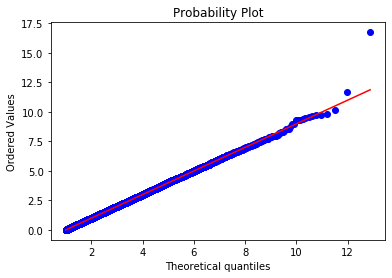

In [530]:
def gen_exp(beta, size = 1, seed = None):
    
    result = -beta * np.log(1 - gen_uni(size = size, seed = seed))
    
    return result

test_set = gen_exp(beta = 1, size = size, seed = 0)

stats.probplot(test_set, sparams = (1/1), dist = "expon", fit = False, plot = pylab)
pylab.show()

## Normal distribution
We will generate normal random variables using the Box-Muller algorithm, the Marsaglia polar algorithm, and the inverse cumulative distribution methods. Of the three, the Marsaglia polar algorithm is theoretically fastest. However, we found the inverse cumulative distribution method was far fastest. Perhaps this is because we used SciPy's inverse normal function, which may be highly optimized. 

In [541]:
# Array to recrod the time to generate the random variables
gen_time = np.zeros(3)

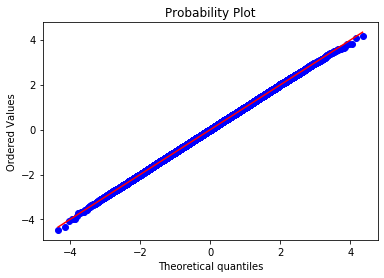

In [542]:
# Box-Muller algorithm
def gen_norm1(mu = 0, sd = 1, size = size, seed = None):
    
    nums = gen_int(size = 2, seed = seed)
    
    n = int(np.ceil(size/2))
    uni_1 = gen_uni(size = n, seed = nums[0])
    uni_2 = gen_uni(size = n, seed = nums[1])
    
    r = np.sqrt(-2 * np.log(uni_1))
    Z_1 = r * np.cos(2 * np.pi * uni_2)
    Z_2 = r * np.sin(2 * np.pi * uni_2)
    
    result = np.concatenate([Z_1, Z_2])[0:size]
    result = mu + sd * result
    
    return result

start = time.time()
test_set = gen_norm1(mu = 0, sd = 1, size = size, seed = 0)
gen_time[0] = time.time() - start

stats.probplot(test_set, sparams = (0, 1), dist = "norm", fit = False, plot = pylab)
pylab.show()

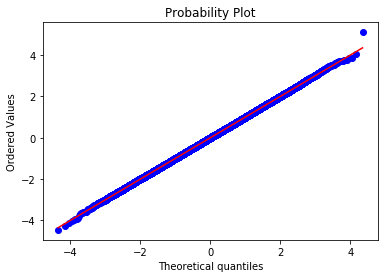

In [543]:
# Marsaglia polar algorithm
def gen_norm2(mu = 0, sd = 1, size = size, seed = None):
    
    nums = gen_int(size = 2, seed = seed)
    
    prob = np.pi/4
    n = int(0.5 * size/prob)
    uni_1 = gen_uni(loc = -1, scale = 2, size = n, seed = nums[0])
    uni_2 = gen_uni(loc = -1, scale = 2, size = n, seed = nums[1])
    
    W = uni_1**2 + uni_2**2
    uni_1 = uni_1[W < 1] 
    uni_2 = uni_2[W < 1]
    W = W[W < 1]
    
    x = np.sqrt(-2 * np.log(W)/W)
    
    result = np.concatenate([uni_1 * x, uni_2 * x])
    
    result = mu + sd * result
    
    nums = nums[0]
    
    if len(result) < size:
        nums = gen_int(size = 1, seed = nums)
        result = np.concatenate([result, gen_norm2(mu = mu, sd = sd, size = size - len(result), seed = nums)])
        
    return result[0:size]

start = time.time()
test_set = gen_norm2(mu = 0, sd = 1, size = size, seed = 0)
gen_time[1] = time.time() - start

stats.probplot(test_set, sparams = (0, 1), dist = "norm", fit = False, plot = pylab)
pylab.show()

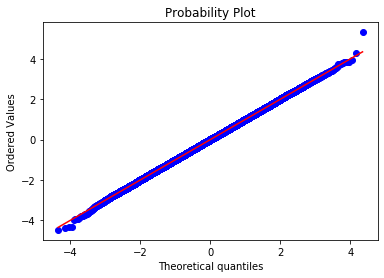

In [544]:
# Inverse cdf
def gen_norm3(mu = 0, sd = 1, size = size, seed = None):

    uni = gen_uni(size = size, seed = seed)
    
    result = sd * stats.norm.ppf(uni) + mu
        
    return result

start = time.time()
test_set = gen_norm3(mu = 0, sd = 1, size = size, seed = 0)
gen_time[2] = time.time() - start

stats.probplot(test_set, sparams = (0, 1), dist = "norm", fit = False, plot = pylab)
pylab.show()

Below are the respective times for the Box-Muller algorithm, Marsaglia polar algorithm, and inverse cdf method. The inverse cdf method was far faster, which is a surprising result.

In [545]:
gen_time

array([0.16447282, 0.13900709, 0.05729413])